# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
from glob import glob
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import math
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from time import time
from skimage import measure


# Import Data

In [ ]:
img_size = 512 #512x512
batch_size = 8

In [ ]:
#define image and mask paths
TEST_IMAGE_PATH = '/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/test/images/'
TEST_MASK_PATH = '/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/test/labels/'

TRAIN_IMAGE_PATH = '/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/train/images/'
TRAIN_MASK_PATH = '/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/train/labels/'

In [ ]:
TRAINED_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/SEM/Trained_model/"

In [ ]:
#read csv
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/counts_test.csv")
bead = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/counts_bead_train_all.csv')
fibre_1crop = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/counts_fibre_1crop_train_all.csv')
fragment_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/counts_fragment_1_train_all.csv')
fragment_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/counts_fragment_2_train_all.csv')

bead.head()

,name,count,class
0,Dove_men_acrylates_copolymer_microbeads_002.png,1,bead
1,Dove_men_acrylates_copolymer_microbeads_004.png,1,bead
2,Dove_men_acrylates_copolymer_microbeads_006.png,1,bead
3,Dove_men_acrylates_copolymer_microbeads_007.png,2,bead
4,Dove_men_acrylates_copolymer_microbeads_016.png,1,bead


In [ ]:
#concat dataframes
frames = [bead, fibre_1crop, fragment_1,fragment_2]
train_df = pd.concat(frames)
train_df = train_df.reset_index(drop=True)
print('Total Train Images: ', len(train_df))
print('Total Test Images: ', len(test_df))

Total Train Images:  624
Total Test Images:  52


# Display Sample Image

Image Size (900, 1280)
Mask Size (900, 1280)


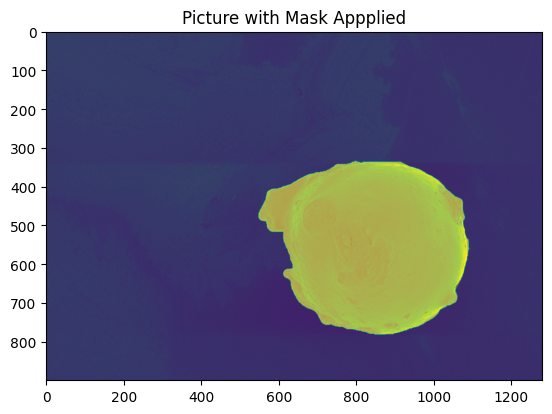

In [ ]:
img = Image.open(TRAIN_IMAGE_PATH + train_df['name'][10])
mask = Image.open(TRAIN_MASK_PATH + train_df['name'][10])
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [ ]:
def visualize(image, mask):
    fontsize = 10
    f, ax = plt.subplots(2, 1, figsize=(6, 6))
    ax[0].imshow(image)
    ax[0].set_title('Image', fontsize=fontsize)
    ax[1].imshow(mask,cmap='Greys_r', interpolation='nearest')
    ax[1].set_title('Mask', fontsize=fontsize)



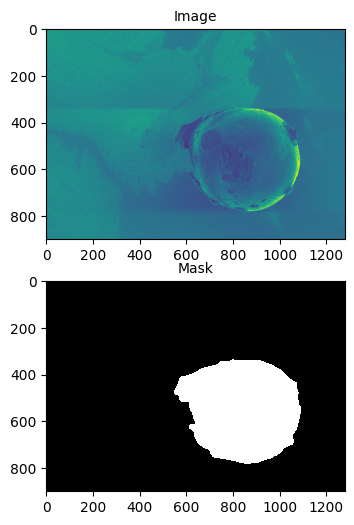

In [ ]:
visualize(img,mask)

# Dataloader

In [ ]:
class MP_SEM_Image_Dataset(Dataset):
    def __init__(self,data_type,dataset_df,transform=None):
        self.data_type = data_type
        self.dataset_df = dataset_df
        self.transform = transform

    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self,index):
        #get shape and count of a file
        shape = self.dataset_df['class'][index]
        count = self.dataset_df['count'][index]

        #get paths
        if self.data_type == "train":
            img_path = os.path.join(TRAIN_IMAGE_PATH,self.dataset_df['name'][index])
            mask_path = os.path.join(TRAIN_MASK_PATH,self.dataset_df['name'][index])
        else: #test
            img_path = os.path.join(TEST_IMAGE_PATH,self.dataset_df['name'][index])
            mask_path = os.path.join(TEST_MASK_PATH,self.dataset_df['name'][index])


        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = np.array(img)
        mask = np.array(mask)

        #scale to 1
        mask = mask.astype('float32') / 255
        img = img.astype('float32')/255


        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)
        return img,mask,shape,count

In [ ]:
#data transformation
data_transform = A.Compose([A.Resize(img_size,img_size),
                             ToTensorV2()])

In [ ]:
train_dataset = MP_SEM_Image_Dataset(data_type = "train",dataset_df = train_df, transform = data_transform)
test_dataset = MP_SEM_Image_Dataset(data_type = "test",dataset_df = test_df, transform = data_transform)


#train and test dataloader
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)

In [ ]:
#check if dataloader is working
dataiter = iter(test_dataloader)
data = next(dataiter)

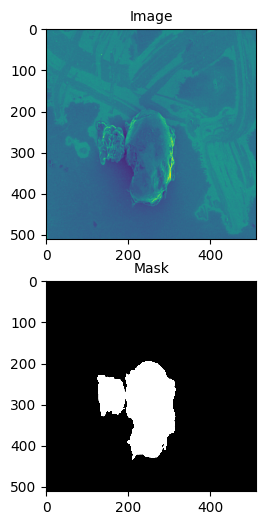

In [ ]:
visualize(data[0][0][0],data[1][0][0])

# ELU-Net

Ref:

https://ieeexplore.ieee.org/document/9745574

https://github.com/FrexG/ELU-Net-pytorch


In [ ]:
class DoubleConv(nn.Module):
    # Conv -> BN -> ReLu

    def __init__(self,in_channels,out_channels) -> None:
        super().__init__()
        self.double_conv = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,3,padding="same",stride=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Conv2d(out_channels,out_channels,3,padding="same",stride=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )

    def forward(self,x):
        return self.double_conv(x)

In [ ]:
class DownSample(nn.Module):
    # MaxPool -> DoubleConv
    def __init__(self,in_channels,out_channels) -> None:
        super().__init__()
        self.down_sample = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels,out_channels)
        )
    def forward(self,x):
        x  = self.down_sample(x)
        return x

In [ ]:
class OutConv(nn.Module):
    #output
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UpSample(nn.Module):
    def __init__(self,in_channels,out_channels,c:int) -> None:
        super().__init__()
        n = 0 if c == 0 else int(math.log(c,2))

        self.upsample = nn.ModuleList(
            [nn.ConvTranspose2d(in_channels,in_channels,2,2) for i in range(n)]
        )
        self.conv_3 = nn.Conv2d(in_channels,out_channels,3,padding="same",stride=1)

    def forward(self,x):
        for layer in self.upsample:
            x = layer(x)
        return self.conv_3(x)

In [ ]:
class ELUnet(nn.Module):
    def __init__(self,in_channels,out_channels,n:int = 8) -> None:
        #in_channels: number of channels of the input
        #out_channels: number of classes
        #n: size of the first encoder layer

        super().__init__()
        # Input convolutions

        self.in_conv = DoubleConv(in_channels,n)

        # Encoder
        self.down_1 = DownSample(n,2*n)
        self.down_2 = DownSample(2*n,4*n)
        self.down_3 = DownSample(4*n,8*n)
        self.down_4 = DownSample(8*n,16*n)


        # Upsampling encoderX side to decoderX side
        self.up_X5_X4 = UpSample(16*n,8*n,2)

        self.up_X4_X1 = UpSample(8*n,n,8)
        self.up_X4_X2 = UpSample(8*n,2*n,4)
        self.up_X4_X3 = UpSample(8*n,4*n,2)
        self.up_X4_X4 = UpSample(8*n,8*n,0)

        self.up_X3_X1 = UpSample(4*n,n,4)
        self.up_X3_X2 = UpSample(4*n,2*n,2)
        self.up_X3_X3 = UpSample(4*n,4*n,0)

        self.up_X2_X1 = UpSample(2*n,n,2)
        self.up_X2_X2 = UpSample(2*n,2*n,0)

        self.up_X1_X1 = UpSample(n,n,0)


        # Decoder
        self.dec_4 = DoubleConv(2*8*n,8*n)
        self.dec_3 = DoubleConv(3*4*n,4*n)
        self.dec_2 = DoubleConv(4*2*n,2*n)
        self.dec_1 = DoubleConv(5*n,n)

        # Output
        self.out_conv = OutConv(n,out_channels)

    def forward(self,x):

        # [8, 16, 32, 64, 128 ]
        # Encoder
        x = self.in_conv(x)
        x_enc_1 = self.down_1(x)
        x_enc_2 = self.down_2(x_enc_1)
        x_enc_3 = self.down_3(x_enc_2)
        x_enc_4 = self.down_4(x_enc_3)

        # Decoder
        x_up_1 = self.up_X5_X4(x_enc_4)
        x_dec_4 = self.dec_4(torch.cat([x_up_1,
                                self.up_X4_X4(x_enc_3)],dim=1))
        x_up_2 = self.up_X4_X3(x_dec_4)
        x_dec_3 = self.dec_3(torch.cat([x_up_2,
                                self.up_X4_X3(x_enc_3),
                                self.up_X3_X3(x_enc_2)],dim=1))

        x_up_3 = self.up_X3_X2(x_dec_3)
        x_dec_2 = self.dec_2(torch.cat([x_up_3,
            self.up_X4_X2(x_enc_3),
            self.up_X3_X2(x_enc_2),
            self.up_X2_X2(x_enc_1)
        ],dim=1))

        x_up_4 = self.up_X2_X1(x_dec_2)
        x_dec_1 = self.dec_1(torch.cat([
            x_up_4,
            self.up_X4_X1(x_enc_3),
            self.up_X3_X1(x_enc_2),
            self.up_X2_X1(x_enc_1),
            self.up_X1_X1(x)
        ],dim=1))

        return self.out_conv(x_dec_1)

In [ ]:
#get summary of model
elunet1 = ELUnet(1,1,8)
elunet1 = elunet1.cuda()
summary(elunet1,(1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]              80
       BatchNorm2d-2          [-1, 8, 512, 512]              16
              ReLU-3          [-1, 8, 512, 512]               0
            Conv2d-4          [-1, 8, 512, 512]             584
       BatchNorm2d-5          [-1, 8, 512, 512]              16
              ReLU-6          [-1, 8, 512, 512]               0
        DoubleConv-7          [-1, 8, 512, 512]               0
         MaxPool2d-8          [-1, 8, 256, 256]               0
            Conv2d-9         [-1, 16, 256, 256]           1,168
      BatchNorm2d-10         [-1, 16, 256, 256]              32
             ReLU-11         [-1, 16, 256, 256]               0
           Conv2d-12         [-1, 16, 256, 256]           2,320
      BatchNorm2d-13         [-1, 16, 256, 256]              32
             ReLU-14         [-1, 16, 2

In [ ]:
print(elunet1)

ELUnet(
  (in_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_1): DownSample(
    (down_sample): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

# Unet++

Ref:


https://github.com/MEDAL-IITB/Lung-Segmentation/blob/master/VGG_UNet/code/build_model.py

https://github.com/4uiiurz1/pytorch-nested-unet/blob/master/archs.py


In [ ]:
class DoubleConvBlock(nn.Module):

    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()
        # Conv -> BN -> ReLu

        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self,x):
        #conv1
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        #conv2
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        return(out)

In [ ]:
class Unet_Plus2(nn.Module):

    def __init__(self, num_classes, input_channels=3, **kwargs):
        super().__init__()


        nb_filter = [8, 16, 32, 64, 128]


        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv0_0 = DoubleConvBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = DoubleConvBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = DoubleConvBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = DoubleConvBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = DoubleConvBlock(nb_filter[3], nb_filter[4], nb_filter[4])


        self.conv0_1 = DoubleConvBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = DoubleConvBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = DoubleConvBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = DoubleConvBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = DoubleConvBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = DoubleConvBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = DoubleConvBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = DoubleConvBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = DoubleConvBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = DoubleConvBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        self.final = nn.Conv2d(nb_filter[0], num_classes, kernel_size=1)

    def forward(self, input_):
        x0_0 = self.conv0_0(input_)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))


        output = self.final(x0_4)
        return output

In [ ]:
#getsummary
model2 = Unet_Plus2(num_classes=1, input_channels=1)
model2 = model2.cuda()
summary(model2,(1,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]              80
       BatchNorm2d-2          [-1, 8, 512, 512]              16
              ReLU-3          [-1, 8, 512, 512]               0
            Conv2d-4          [-1, 8, 512, 512]             584
       BatchNorm2d-5          [-1, 8, 512, 512]              16
              ReLU-6          [-1, 8, 512, 512]               0
   DoubleConvBlock-7          [-1, 8, 512, 512]               0
         MaxPool2d-8          [-1, 8, 256, 256]               0
            Conv2d-9         [-1, 16, 256, 256]           1,168
      BatchNorm2d-10         [-1, 16, 256, 256]              32
             ReLU-11         [-1, 16, 256, 256]               0
           Conv2d-12         [-1, 16, 256, 256]           2,320
      BatchNorm2d-13         [-1, 16, 256, 256]              32
             ReLU-14         [-1, 16, 2

In [ ]:
print(model2)

Unet_Plus2(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): DoubleConvBlock(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): DoubleConvBlock(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): DoubleConvBlock(
    (conv1): Conv2

# Train and Test Functions

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count+=n
        self.avg = self.sum/self.count


class BCEDiceLoss(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self,input,target):
        bce = F.binary_cross_entropy_with_logits(input,target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num,-1)
        target = target.view(num,-1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return (0.5 * bce + dice)


def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)


def dice_coef(output, target):
    smooth = 1e-5
    output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()
    return (2. * intersection + smooth) / (output.sum() + target.sum() + smooth)



In [ ]:
def train(train_loader, model, criterion, optimizer):
    avg_meters = {'loss':AverageMeter(),'iou':AverageMeter(), 'dice_coef':AverageMeter()}
    model.train()

    for X, Y,_,_ in train_loader:
        #image
        X= X.cuda()
        #mask
        Y = Y.cuda()

        #predict
        Y_pred = model(X)
        #calculate loss
        loss = criterion(Y_pred,Y)
        iou = iou_score(Y_pred,Y)
        dice_score = dice_coef(Y_pred,Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #update metrics
        avg_meters['loss'].update(loss.item(), X.size(0))
        avg_meters['iou'].update(iou, X.size(0))
        avg_meters['dice_coef'].update(dice_score, X.size(0))

        postfix = OrderedDict([('loss',avg_meters['loss'].avg),('iou', avg_meters['iou'].avg),('dice_coef', avg_meters['dice_coef'].avg)])


    return OrderedDict([('loss', avg_meters['loss'].avg),('iou', avg_meters['iou'].avg),('dice_coef', avg_meters['dice_coef'].avg)])

In [ ]:
def test(test_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),'iou': AverageMeter(),'dice_coef':AverageMeter()}

    #  evaluate mode
    model.eval()

    with torch.no_grad():

        for X, Y, _,_ in test_loader:
            X = X.cuda()
            Y = Y.cuda()

            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            iou = iou_score(Y_pred, Y)
            dice_score = dice_coef(Y_pred,Y)
            #update metrics
            avg_meters['loss'].update(loss.item(), X.size(0))
            avg_meters['iou'].update(iou, X.size(0))
            avg_meters['dice_coef'].update(dice_score, X.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
                ('dice_coef',avg_meters['dice_coef'].avg)
            ])

    return OrderedDict([('loss', avg_meters['loss'].avg),('iou', avg_meters['iou'].avg),('dice_coef', avg_meters['dice_coef'].avg)])

# Model1 - ELU-Net

In [ ]:

model_name = "Model1_ELUnet"
model = ELUnet(1,1,8)

model = model.cuda()
#print(model)
learning_rate = 1e-3

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
num_epochs = 60

criterion = BCEDiceLoss().cuda()
params = filter(lambda p: p.requires_grad, model.parameters())
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)


log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('iou', []),
    ('dice',[]),
    ('test_loss', []),
    ('test_iou', []),
    ('test_dice',[])
])

start_time = time()
for epoch in range(num_epochs):
    print('Epoch %d : ' % (epoch))

    # train
    train_log = train(train_dataloader, model, criterion, optimizer)

    # evaluate on test set
    test_log = test(test_dataloader, model, criterion)

    scheduler.step()

    print('loss %.4f - iou %.4f - dice %.4f - test_loss %.4f - test_iou %.4f - test_dice %.4f'
          % (train_log['loss'], train_log['iou'], train_log['dice_coef'],test_log['loss'], test_log['iou'], test_log['dice_coef']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['dice'].append(train_log['dice_coef'])
    log['test_loss'].append(test_log['loss'])
    log['test_iou'].append(test_log['iou'])
    log['test_dice'].append(test_log['dice_coef'])

    #save log to csv
    pd.DataFrame(log).to_csv(TRAINED_MODEL_PATH+model_name+'_log.csv', index=False)
    torch.cuda.empty_cache()



end_time = time()
total_time = end_time - start_time
print("total time: "+ str(total_time))

Epoch 0 : 
loss 0.9727 - iou 0.3830 - dice 0.2910 - test_loss 0.9173 - test_iou 0.4590 - test_dice 0.3173
Epoch 1 : 
loss 0.7939 - iou 0.5186 - dice 0.3986 - test_loss 0.6564 - test_iou 0.6386 - test_dice 0.4856
Epoch 2 : 
loss 0.6370 - iou 0.6090 - dice 0.5009 - test_loss 0.8576 - test_iou 0.4206 - test_dice 0.4561
Epoch 3 : 
loss 0.5243 - iou 0.6332 - dice 0.5936 - test_loss 0.4355 - test_iou 0.7186 - test_dice 0.6690
Epoch 4 : 
loss 0.3892 - iou 0.7083 - dice 0.7003 - test_loss 0.7069 - test_iou 0.5302 - test_dice 0.5882
Epoch 5 : 
loss 0.3248 - iou 0.7253 - dice 0.7516 - test_loss 0.3233 - test_iou 0.7356 - test_dice 0.7655
Epoch 6 : 
loss 0.2767 - iou 0.7449 - dice 0.7923 - test_loss 0.2599 - test_iou 0.7518 - test_dice 0.8081
Epoch 7 : 
loss 0.2411 - iou 0.7643 - dice 0.8195 - test_loss 0.2461 - test_iou 0.7632 - test_dice 0.8285
Epoch 8 : 
loss 0.2090 - iou 0.7874 - dice 0.8435 - test_loss 0.3556 - test_iou 0.6613 - test_dice 0.7419
Epoch 9 : 
loss 0.2035 - iou 0.7840 - dice 0.8

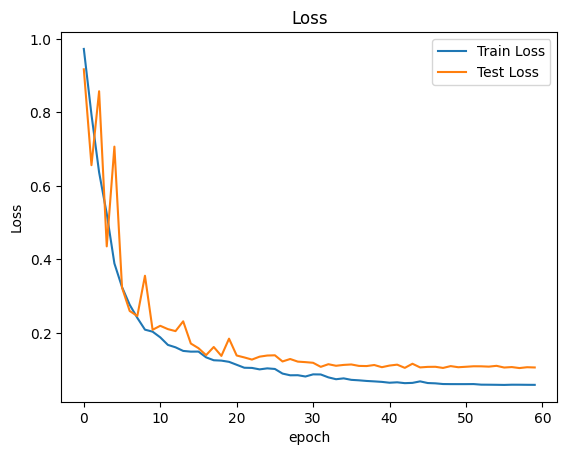

In [ ]:
#plot of accuracies of the models
plt.plot(log['loss'],label='Train Loss')
plt.plot(log['test_loss'],label='Test Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()


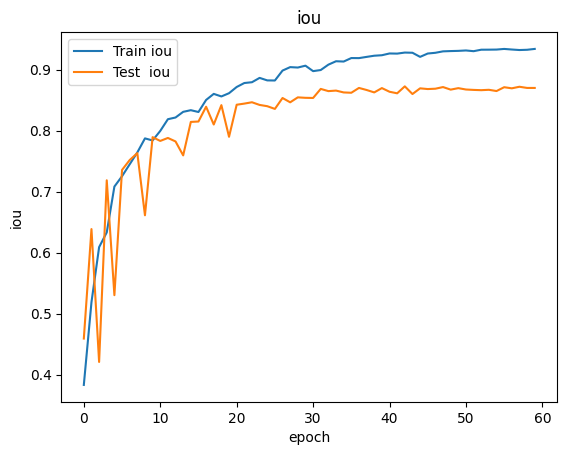

In [ ]:
#plot of accuracies of the models
plt.plot(log['iou'],label='Train iou')
plt.plot(log['test_iou'],label='Test  iou')
plt.xlabel('epoch')
plt.ylabel('iou')
plt.title('iou')
plt.legend()
plt.show()


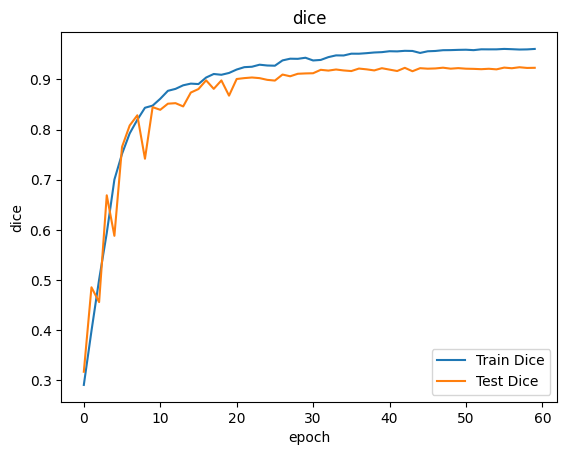

In [ ]:
#plot of accuracies of the models
plt.plot(log['dice'],label='Train Dice')
plt.plot(log['test_dice'],label='Test Dice')
plt.xlabel('epoch')
plt.ylabel('dice')
plt.title('dice')
plt.legend()
plt.show()


In [ ]:
#copy model1 metrics
log_model1 = log.copy()

In [ ]:
TRAINED_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/SEM/Trained_model/"
#save the model
TRAINED_FILE =TRAINED_MODEL_PATH + model_name +".pth"
torch.save(model.state_dict(), TRAINED_FILE)

# Model2 - Unet++
Adam Optimizer

In [ ]:
#define model
model_name = "Model2_Unet_Plus2"
model = Unet_Plus2(num_classes=1, input_channels=1)



model = model.cuda()
#print(model)
learning_rate = 1e-3

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
num_epochs = 60
criterion = BCEDiceLoss().cuda()
params = filter(lambda p: p.requires_grad, model.parameters())
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)


log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('iou', []),
    ('dice',[]),
    ('test_loss', []),
    ('test_iou', []),
    ('test_dice',[])
])

start_time = time()
for epoch in range(num_epochs):
    print('Epoch %d : ' % (epoch))

    # train
    train_log = train(train_dataloader, model, criterion, optimizer)

    # evaluate on test set
    test_log = test(test_dataloader, model, criterion)

    scheduler.step()

    print('loss %.4f - iou %.4f - dice %.4f - test_loss %.4f - test_iou %.4f - test_dice %.4f'
          % (train_log['loss'], train_log['iou'], train_log['dice_coef'],test_log['loss'], test_log['iou'], test_log['dice_coef']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['dice'].append(train_log['dice_coef'])
    log['test_loss'].append(test_log['loss'])
    log['test_iou'].append(test_log['iou'])
    log['test_dice'].append(test_log['dice_coef'])

    #save log to csv
    pd.DataFrame(log).to_csv(TRAINED_MODEL_PATH + model_name+'_log.csv', index=False)
    torch.cuda.empty_cache()



end_time = time()
total_time = end_time - start_time
print("total time: "+ str(total_time))

Epoch 0 : 
loss 1.0217 - iou 0.3006 - dice 0.2733 - test_loss 0.8963 - test_iou 0.4648 - test_dice 0.3221
Epoch 1 : 
loss 0.8600 - iou 0.4770 - dice 0.3624 - test_loss 0.7912 - test_iou 0.5904 - test_dice 0.3882
Epoch 2 : 
loss 0.6906 - iou 0.5739 - dice 0.4731 - test_loss 0.6078 - test_iou 0.6600 - test_dice 0.5278
Epoch 3 : 
loss 0.5200 - iou 0.6686 - dice 0.5999 - test_loss 0.4833 - test_iou 0.6702 - test_dice 0.6301
Epoch 4 : 
loss 0.4177 - iou 0.6832 - dice 0.6780 - test_loss 0.4475 - test_iou 0.6366 - test_dice 0.6585
Epoch 5 : 
loss 0.3169 - iou 0.7330 - dice 0.7559 - test_loss 0.3325 - test_iou 0.7205 - test_dice 0.7562
Epoch 6 : 
loss 0.2642 - iou 0.7577 - dice 0.7984 - test_loss 0.7090 - test_iou 0.5016 - test_dice 0.6005
Epoch 7 : 
loss 0.2486 - iou 0.7512 - dice 0.8106 - test_loss 0.2646 - test_iou 0.7433 - test_dice 0.7939
Epoch 8 : 
loss 0.2037 - iou 0.7943 - dice 0.8476 - test_loss 0.2637 - test_iou 0.7395 - test_dice 0.8040
Epoch 9 : 
loss 0.1817 - iou 0.8092 - dice 0.8

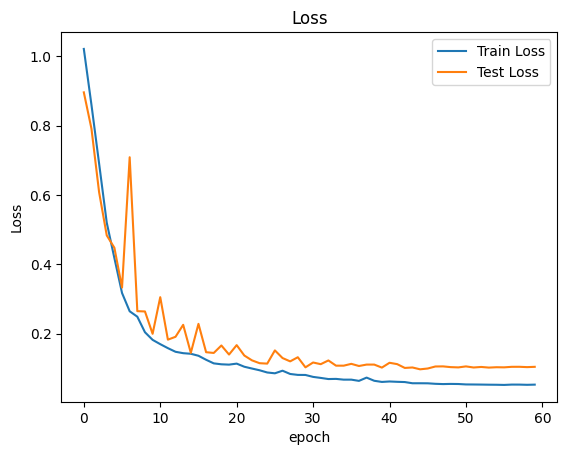

In [ ]:
#plot of accuracies of the models
plt.plot(log['loss'],label='Train Loss')
plt.plot(log['test_loss'],label='Test Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()


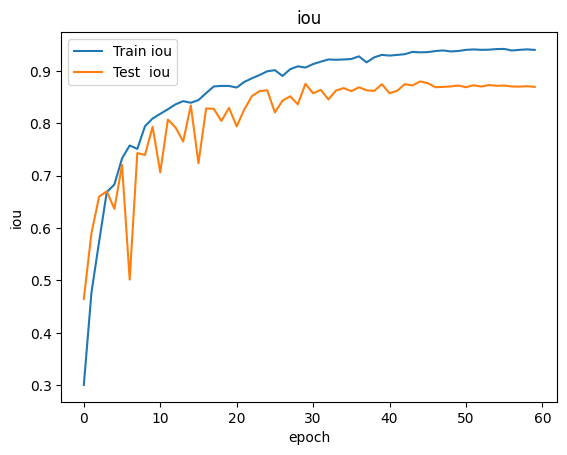

In [ ]:
#plot of accuracies of the models
plt.plot(log['iou'],label='Train iou')
plt.plot(log['test_iou'],label='Test  iou')
plt.xlabel('epoch')
plt.ylabel('iou')
plt.title('iou')
plt.legend()
plt.show()


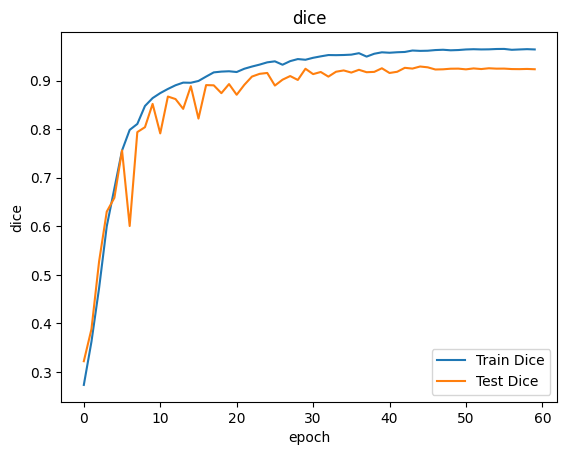

In [ ]:
#plot of accuracies of the models
plt.plot(log['dice'],label='Train Dice')
plt.plot(log['test_dice'],label='Test Dice')
plt.xlabel('epoch')
plt.ylabel('dice')
plt.title('dice')
plt.legend()
plt.show()


In [ ]:
log_model2 = log.copy()

In [ ]:
TRAINED_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/SEM/Trained_model/"
#save the model
TRAINED_FILE =TRAINED_MODEL_PATH + model_name +".pth"
torch.save(model.state_dict(), TRAINED_FILE)

# Model3 - Unet++
SGD Optimizer

In [ ]:
#define model
model_name = "Model3_Unet_Plus2"
model = Unet_Plus2(num_classes=1, input_channels=1)


model = model.cuda()
#print(model)
learning_rate = 1e-3

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.95)
num_epochs = 60
criterion = BCEDiceLoss().cuda()
params = filter(lambda p: p.requires_grad, model.parameters())
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)


log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('iou', []),
    ('dice',[]),
    ('test_loss', []),
    ('test_iou', []),
    ('test_dice',[])
])

start_time = time()
for epoch in range(num_epochs):
    print('Epoch %d : ' % (epoch))

    # train
    train_log = train(train_dataloader, model, criterion, optimizer)

    # evaluate on test set
    test_log = test(test_dataloader, model, criterion)

    scheduler.step()

    print('loss %.4f - iou %.4f - dice %.4f - test_loss %.4f - test_iou %.4f - test_dice %.4f'
          % (train_log['loss'], train_log['iou'], train_log['dice_coef'],test_log['loss'], test_log['iou'], test_log['dice_coef']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['iou'].append(train_log['iou'])
    log['dice'].append(train_log['dice_coef'])
    log['test_loss'].append(test_log['loss'])
    log['test_iou'].append(test_log['iou'])
    log['test_dice'].append(test_log['dice_coef'])

    #save log to csv
    pd.DataFrame(log).to_csv(TRAINED_MODEL_PATH + model_name+'_log.csv', index=False)
    torch.cuda.empty_cache()



end_time = time()
total_time = end_time - start_time
print("total time: "+ str(total_time))

Epoch 0 : 
loss 1.0336 - iou 0.2459 - dice 0.2428 - test_loss 0.9074 - test_iou 0.3910 - test_dice 0.2985
Epoch 1 : 
loss 0.8553 - iou 0.4098 - dice 0.3459 - test_loss 0.8841 - test_iou 0.4040 - test_dice 0.3925
Epoch 2 : 
loss 0.7012 - iou 0.4894 - dice 0.4499 - test_loss 0.6171 - test_iou 0.5702 - test_dice 0.5270
Epoch 3 : 
loss 0.5410 - iou 0.5774 - dice 0.5757 - test_loss 0.5077 - test_iou 0.5966 - test_dice 0.6121
Epoch 4 : 
loss 0.4431 - iou 0.6065 - dice 0.6506 - test_loss 0.4324 - test_iou 0.6328 - test_dice 0.6577
Epoch 5 : 
loss 0.3485 - iou 0.6707 - dice 0.7276 - test_loss 0.3611 - test_iou 0.6574 - test_dice 0.7227
Epoch 6 : 
loss 0.3237 - iou 0.6739 - dice 0.7491 - test_loss 0.3141 - test_iou 0.7021 - test_dice 0.7670
Epoch 7 : 
loss 0.2963 - iou 0.6920 - dice 0.7716 - test_loss 0.2866 - test_iou 0.7099 - test_dice 0.7818
Epoch 8 : 
loss 0.2642 - iou 0.7183 - dice 0.7961 - test_loss 0.2856 - test_iou 0.7153 - test_dice 0.7941
Epoch 9 : 
loss 0.2374 - iou 0.7423 - dice 0.8

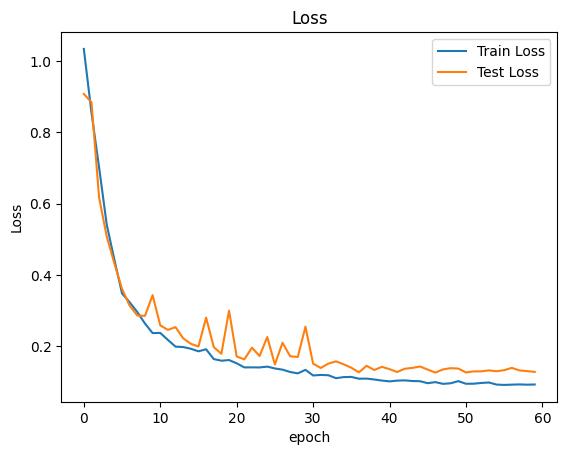

In [ ]:
#plot of accuracies of the models
plt.plot(log['loss'],label='Train Loss')
plt.plot(log['test_loss'],label='Test Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()


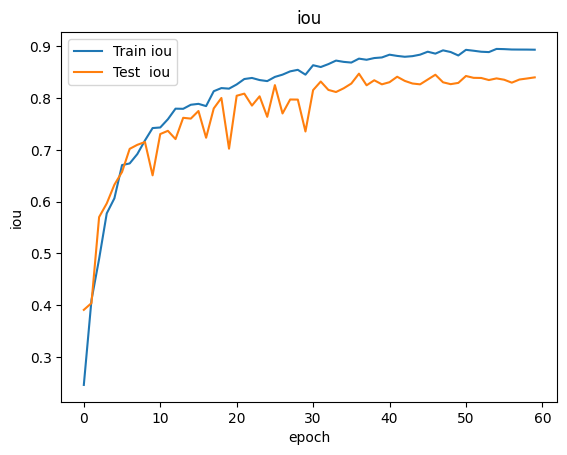

In [ ]:
#plot of accuracies of the models
plt.plot(log['iou'],label='Train iou')
plt.plot(log['test_iou'],label='Test  iou')
plt.xlabel('epoch')
plt.ylabel('iou')
plt.title('iou')
plt.legend()
plt.show()


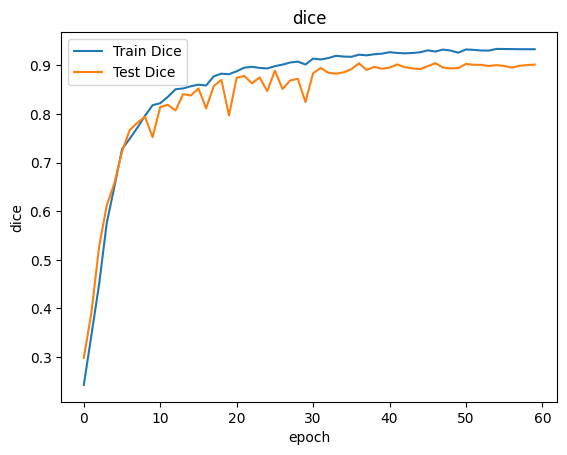

In [ ]:
#plot of accuracies of the models
plt.plot(log['dice'],label='Train Dice')
plt.plot(log['test_dice'],label='Test Dice')
plt.xlabel('epoch')
plt.ylabel('dice')
plt.title('dice')
plt.legend()
plt.show()


In [ ]:
log_model3 = log.copy()

In [ ]:
TRAINED_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/SEM/Trained_model/"
#save the model
TRAINED_FILE =TRAINED_MODEL_PATH + model_name +".pth"
torch.save(model.state_dict(), TRAINED_FILE)

# Plots

In [ ]:
#plot the results. Load the csv logs.
model1_log = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SEM/Trained_model/Model1_ELUnet_log.csv")
model2_log = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SEM/Trained_model/Model2_Unet_Plus2_log.csv")
model3_log = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SEM/Trained_model/Model3_Unet_Plus2_log.csv")
model5_log = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SEM/Trained_model/Unet_Plus2_adam_LR_0_03_log.csv")
model6_log = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SEM/Trained_model/Unet_Plus2_adam_LR_0_01_log.csv")

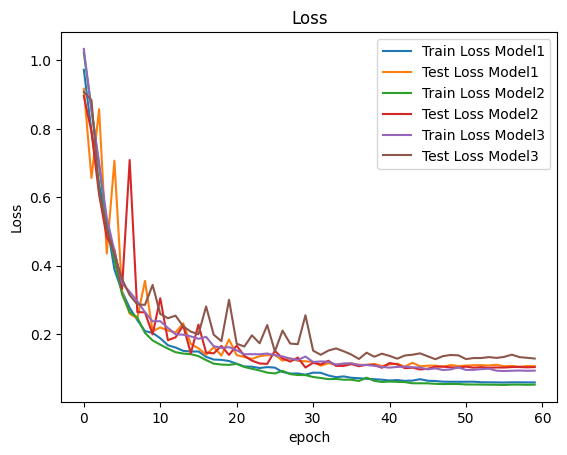

In [ ]:
#plot of loss of the models
plt.plot(model1_log['loss'],label='Train Loss Model1')
plt.plot(model1_log['test_loss'],label='Test Loss Model1')
plt.plot(model2_log['loss'],label='Train Loss Model2')
plt.plot(model2_log['test_loss'],label='Test Loss Model2')
plt.plot(model3_log['loss'],label='Train Loss Model3')
plt.plot(model3_log['test_loss'],label='Test Loss Model3')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()


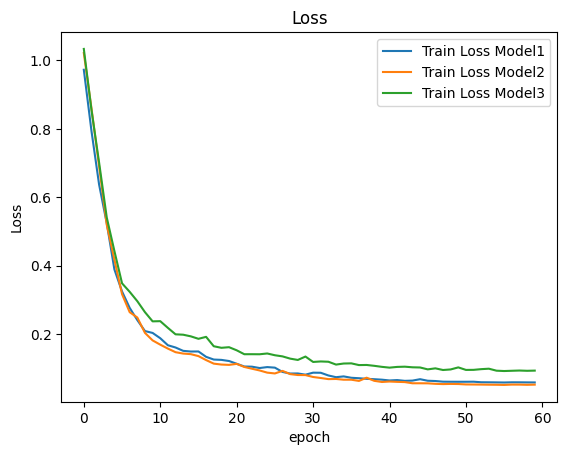

In [ ]:
#plot of train loss of the models
plt.plot(model1_log['loss'],label='Train Loss Model1')
#plt.plot(model1_log['test_loss'],label='Test Loss Model1')
plt.plot(model2_log['loss'],label='Train Loss Model2')
#plt.plot(model2_log['test_loss'],label='Test Loss Model2')
plt.plot(model3_log['loss'],label='Train Loss Model3')
#plt.plot(model3_log['test_loss'],label='Test Loss Model3')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()


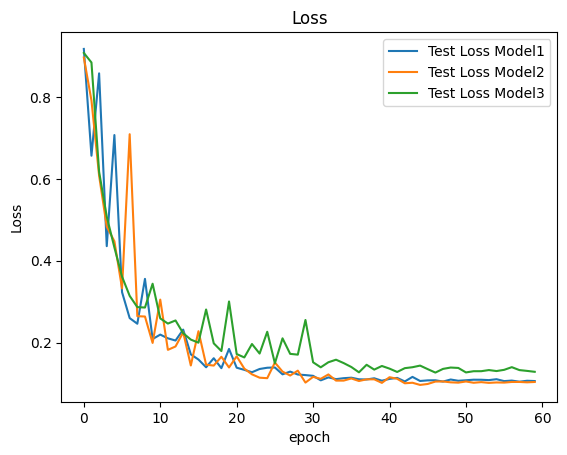

In [ ]:
#plot of test loss  of the models
#plt.plot(model1_log['loss'],label='Train Loss Model1')
plt.plot(model1_log['test_loss'],label='Test Loss Model1')
#plt.plot(model2_log['loss'],label='Train Loss Model2')
plt.plot(model2_log['test_loss'],label='Test Loss Model2')
#plt.plot(model3_log['loss'],label='Train Loss Model3')
plt.plot(model3_log['test_loss'],label='Test Loss Model3')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()


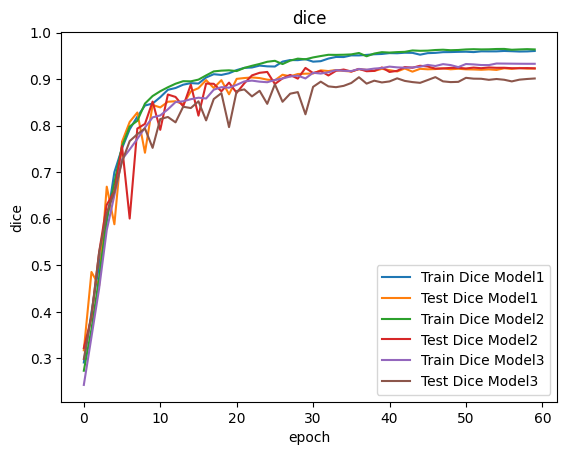

In [ ]:
#plot of dice of the models
plt.plot(model1_log['dice'],label='Train Dice Model1')
plt.plot(model1_log['test_dice'],label='Test Dice Model1')
plt.plot(model2_log['dice'],label='Train Dice Model2')
plt.plot(model2_log['test_dice'],label='Test Dice Model2')
plt.plot(model3_log['dice'],label='Train Dice Model3')
plt.plot(model3_log['test_dice'],label='Test Dice Model3')
plt.xlabel('epoch')
plt.ylabel('dice')
plt.title('dice')
plt.legend()
plt.show()


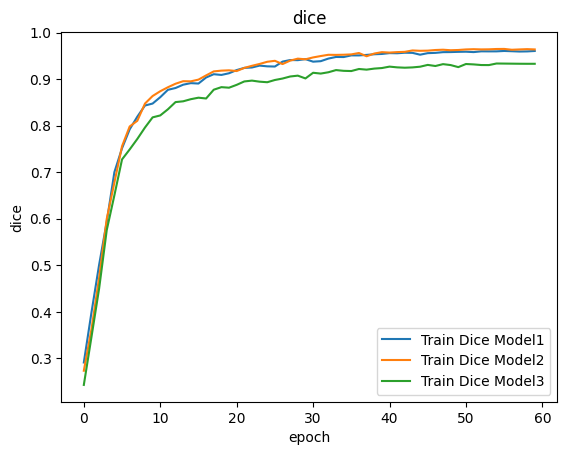

In [ ]:
#plot of train dice of the models
plt.plot(model1_log['dice'],label='Train Dice Model1')
#plt.plot(model1_log['test_dice'],label='Test Dice Model1')
plt.plot(model2_log['dice'],label='Train Dice Model2')
#plt.plot(model2_log['test_dice'],label='Test Dice Model2')
plt.plot(model3_log['dice'],label='Train Dice Model3')
#plt.plot(model3_log['test_dice'],label='Test Dice Model3')
plt.xlabel('epoch')
plt.ylabel('dice')
plt.title('dice')
plt.legend()
plt.show()


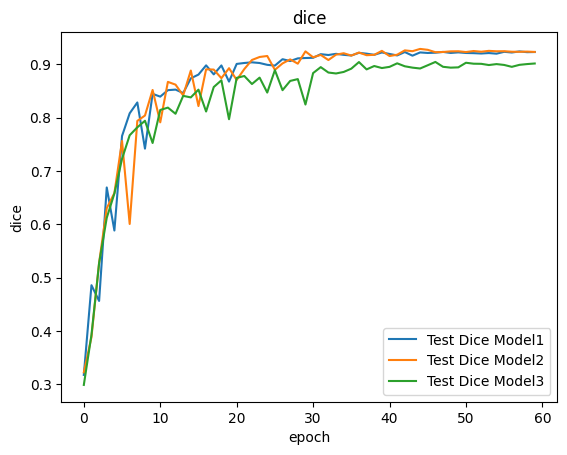

In [ ]:
#plot of test dice of the models
#plt.plot(model1_log['dice'],label='Train Dice Model1')
plt.plot(model1_log['test_dice'],label='Test Dice Model1')
#plt.plot(model2_log['dice'],label='Train Dice Model2')
plt.plot(model2_log['test_dice'],label='Test Dice Model2')
#plt.plot(model3_log['dice'],label='Train Dice Model3')
plt.plot(model3_log['test_dice'],label='Test Dice Model3')

plt.xlabel('epoch')
plt.ylabel('dice')
plt.title('dice')
plt.legend()
plt.show()


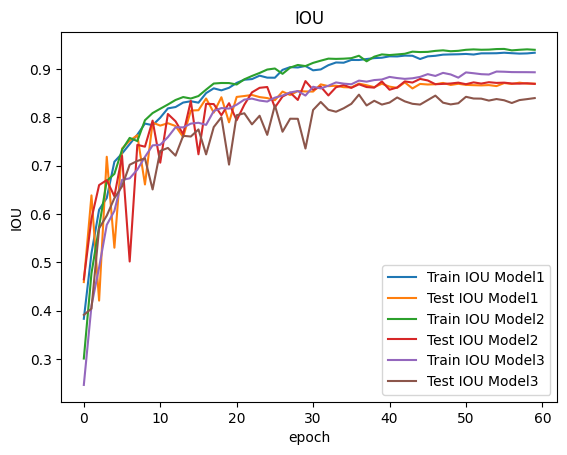

In [ ]:
#plot of iou of the models
plt.plot(model1_log['iou'],label='Train IOU Model1')
plt.plot(model1_log['test_iou'],label='Test IOU Model1')
plt.plot(model2_log['iou'],label='Train IOU Model2')
plt.plot(model2_log['test_iou'],label='Test IOU Model2')
plt.plot(model3_log['iou'],label='Train IOU Model3')
plt.plot(model3_log['test_iou'],label='Test IOU Model3')
plt.xlabel('epoch')
plt.ylabel('IOU')
plt.title('IOU')
plt.legend()
plt.show()


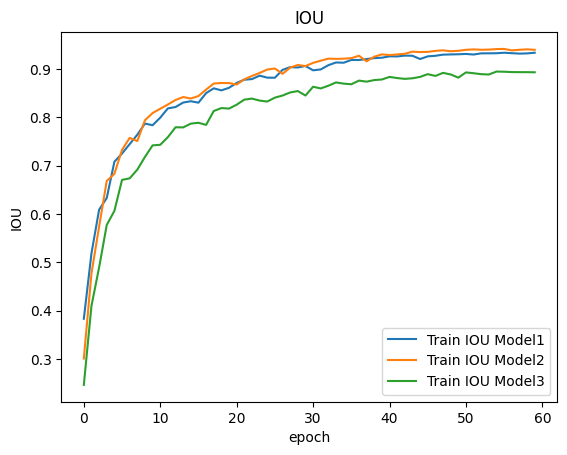

In [ ]:
#plot of train iou of the models
plt.plot(model1_log['iou'],label='Train IOU Model1')
#plt.plot(model1_log['test_iou'],label='Test IOU Model1')
plt.plot(model2_log['iou'],label='Train IOU Model2')
#plt.plot(model2_log['test_iou'],label='Test IOU Model2')
plt.plot(model3_log['iou'],label='Train IOU Model3')
#plt.plot(model3_log['test_iou'],label='Test IOU Model3')
plt.xlabel('epoch')
plt.ylabel('IOU')
plt.title('IOU')
plt.legend()
plt.show()


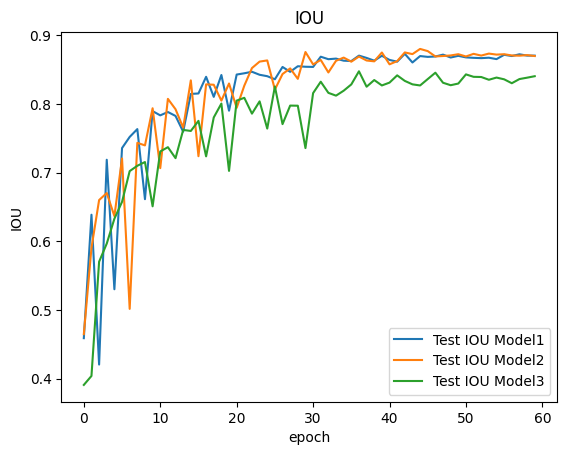

In [ ]:
#plot of test iou of the models
#plt.plot(model1_log['iou'],label='Train IOU Model1')
plt.plot(model1_log['test_iou'],label='Test IOU Model1')
#plt.plot(model2_log['iou'],label='Train IOU Model2')
plt.plot(model2_log['test_iou'],label='Test IOU Model2')
#plt.plot(model3_log['iou'],label='Train IOU Model3')
plt.plot(model3_log['test_iou'],label='Test IOU Model3')
plt.xlabel('epoch')
plt.ylabel('IOU')
plt.title('IOU')
plt.legend()
plt.show()


# Sample Test Image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
test_iter = iter(test_dataloader)
test_data_iter = next(test_iter)

In [ ]:
test_transform = A.Compose([A.Resize(img_size,img_size),
                           ToTensorV2()])

In [ ]:

#loading the saved model. Use the best model which is Model2
Unet_Plus2_TRAINED = "/content/drive/MyDrive/Colab Notebooks/SEM/Trained_model/Model2_Unet_Plus2.pth"
trained_model = Unet_Plus2(num_classes=1, input_channels=1)
trained_model.load_state_dict(torch.load(Unet_Plus2_TRAINED))
trained_model = trained_model.to("cuda")
trained_model.eval()

Unet_Plus2(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): DoubleConvBlock(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): DoubleConvBlock(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): DoubleConvBlock(
    (conv1): Conv2

In [ ]:
pred = trained_model(test_data_iter[0].to(device))
pred.shape

torch.Size([8, 1, 512, 512])

In [ ]:
pred= pred.sigmoid()
pred = (pred > 0.5).float()

In [ ]:
display_test_img = test_data_iter[0][0].cpu().detach().numpy()
print(display_test_img.shape)
display_test_img = display_test_img.transpose(1,2,0)

(1, 512, 512)


In [ ]:
mask = pred[0].cpu().detach().numpy()
mask = mask.transpose(1,2,0)

In [ ]:
orig_mask = test_data_iter[1][0].cpu().detach().numpy()
orig_mask = orig_mask.transpose(1,2,0)

In [ ]:
def test_visualize(display_test_img,orig_mask, mask):
    fontsize = 10
    f, ax = plt.subplots(1, 3, figsize=(6, 6))
    ax[0].imshow(display_test_img)
    ax[0].set_title('Test Image', fontsize=fontsize)
    ax[1].imshow(orig_mask,cmap='Greys_r', interpolation='nearest')
    ax[1].set_title('Test Mask', fontsize=fontsize)
    ax[2].imshow(mask,cmap='Greys_r', interpolation='nearest')
    ax[2].set_title('Predicted Mask', fontsize=fontsize)


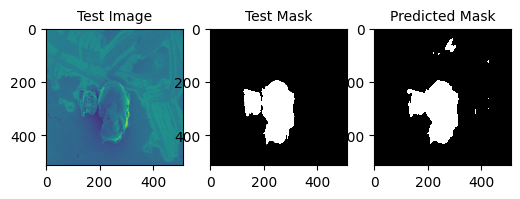

In [ ]:
test_visualize(display_test_img,orig_mask,mask)

# Dice and IoU of original images

-predicted mask resized to original mask size
-calc. iou and dice

In [ ]:
def iou_score_mod(output, target):
    #modified iou function
    smooth = 1e-5
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)


def dice_coef_mod(output, target):
    #modified dice function
    smooth = 1e-5
    intersection = (output * target).sum()
    return (2 * intersection + smooth) / (output.sum() + target.sum() + smooth)

In [ ]:
def dice_iou_orig_image_size(data_df,image_path,mask_path):
    dice_log =0
    iou_log = 0

    for i in data_df['name']:
      iou = 0
      dice_score=0


      #original mask
      maskpath =mask_path + i
      mask_o= cv2.imread(maskpath,cv2.IMREAD_GRAYSCALE)
      maskshape = mask_o.shape
      h = maskshape[0]
      w = maskshape[1]

      img_path = image_path + i
      img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
      img = np.array(img)


      #scale to 1
      img = img.astype('float32')/255
      img = data_transform(image =img )
      img = img["image"]
      img = torch.unsqueeze(img,0)
      #print(img)
      pred = trained_model(img.to(device))
      pred= pred.sigmoid()
      pred = (pred > 0.5).float()

      mask = pred[0].cpu().detach().numpy().copy()

      mask = cv2.resize(mask[0],(w,h))

      iou = iou_score_mod(torch.from_numpy(mask),torch.from_numpy(mask_o/255))
      dice_score = dice_coef_mod(torch.from_numpy(mask),torch.from_numpy(mask_o/255))


      dice_score=dice_score.numpy()
      dice_score=dice_score.astype(float)
      dice_score=dice_score.tolist()

      iou=iou.numpy()
      iou=iou.astype(float)
      iou=iou.tolist()


      #running dice and iou
      dice_log +=dice_score
      iou_log += iou


    #average total
    dice_ave = dice_log/len(data_df)
    iou_ave = iou_log/len(data_df)

    return dice_ave , iou_ave

model1

In [ ]:
#loading the saved model1
ELUNET_TRAINED = "/content/drive/MyDrive/Colab Notebooks/SEM/Trained_model/Model1_ELUnet.pth"
trained_model = ELUnet(1,1,8)
trained_model.load_state_dict(torch.load(ELUNET_TRAINED))
trained_model = trained_model.to("cuda")
trained_model.eval()

ELUnet(
  (in_conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_1): DownSample(
    (down_sample): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [ ]:
dice, iou = dice_iou_orig_image_size(test_df,TEST_IMAGE_PATH,TEST_MASK_PATH)

In [ ]:
#model1
print("DICE : "+ str(dice))
print("IOU : "+str(iou))

DICE : 0.9285566681686759
IOU : 0.8757143100866904


model2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#loading the saved model. Use the best model which is Model2
Unet_Plus2_TRAINED = "/content/drive/MyDrive/Colab Notebooks/SEM/Trained_model/Model2_Unet_Plus2.pth"
trained_model = Unet_Plus2(num_classes=1, input_channels=1)
trained_model.load_state_dict(torch.load(Unet_Plus2_TRAINED))
trained_model = trained_model.to("cuda")
trained_model.eval()

Unet_Plus2(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): DoubleConvBlock(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): DoubleConvBlock(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): DoubleConvBlock(
    (conv1): Conv2

In [ ]:
dice, iou = dice_iou_orig_image_size(test_df,TEST_IMAGE_PATH,TEST_MASK_PATH)

In [ ]:
#model2
print("DICE : "+ str(dice))
print("IOU : "+str(iou))

DICE : 0.9310221853558609
IOU : 0.8785506120094886


model3

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#loading the saved model. Use the best model which is Model2
Unet_Plus2_TRAINED = "/content/drive/MyDrive/Colab Notebooks/SEM/Trained_model/Model3_Unet_Plus2.pth"
trained_model = Unet_Plus2(num_classes=1, input_channels=1)
trained_model.load_state_dict(torch.load(Unet_Plus2_TRAINED))
trained_model = trained_model.to("cuda")
trained_model.eval()

Unet_Plus2(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (conv0_0): DoubleConvBlock(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): DoubleConvBlock(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_0): DoubleConvBlock(
    (conv1): Conv2

In [ ]:
dice, iou = dice_iou_orig_image_size(test_df,TEST_IMAGE_PATH,TEST_MASK_PATH)

In [ ]:
#model3
print("DICE : "+ str(dice))
print("IOU : "+str(iou))

DICE : 0.9145787831095975
IOU : 0.8501850756315085


# Quantification

In [ ]:
def get_count(image):
    number_of_objects=0
    img=np.copy(image)
    blob_labels=measure.label(img,background=0)
    c=np.unique(blob_labels)
    regions = measure.regionprops(blob_labels)
    labels = [(r.area, r.label) for r in regions]

    for r in regions:
      if r.area > 200: #count only regions above 200
        number_of_objects+=1
    return number_of_objects

In [ ]:
def count_image(data_df,image_path):
  count_df = data_df.copy()
  count_list=[]
  for i in data_df['name']:
    img_path = image_path + i
    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    img = np.array(img)
    img = img.astype('float32')/255

    img = data_transform(image =img )

    img = img["image"]

    img = torch.unsqueeze(img,0)
    #print(img)
    pred = trained_model(img.to(device))
    pred= pred.sigmoid()
    pred = (pred > 0.5).float()

    mask = pred[0].cpu().detach().numpy()
    mask = mask.astype(np.uint8)
    number_of_objects = get_count(mask[0])
    count_list.append(number_of_objects)
  #save the counts
  count_df.insert(3,"pred_count",count_list,True)
  return count_df

In [ ]:
result = count_image(test_df,TEST_IMAGE_PATH)

In [ ]:
true_count = result["count"].sum()
pred_count =result["pred_count"].sum()
print("total count: "+ str(true_count))
print("predicted count: "+ str(pred_count))


total count: 172
predicted count: 132


In [ ]:
fname = TRAINED_MODEL_PATH + "object_quantification.csv"
result.to_csv(fname,index=False)

# Segment Image

Segment the train and test folders . Segmented images will be used in image classification.

In [ ]:
SEGMENTED_TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/SEM/Segmented_Microplastic_SEM_Images/train/"
SEGMENTED_TEST_PATH = "/content/drive/MyDrive/Colab Notebooks/SEM/Segmented_Microplastic_SEM_Images/test/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

segment_transform = A.Compose([A.Resize(img_size,img_size),
                           ])

In [ ]:
def segment_image(data_df,image_path,segment_path):
  for i in data_df['name']:
    img_path = image_path + i
    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    img = np.array(img)
    resized_img = segment_transform(image =img )
    #scale to 1
    img = img.astype('float32')/255
    img = data_transform(image =img )
    img = img["image"]
    img = torch.unsqueeze(img,0)
    #print(img)
    pred = trained_model(img.to(device))
    pred= pred.sigmoid()
    pred = (pred > 0.5).float()

    mask = pred[0].cpu().detach().numpy()
    resized_img= resized_img['image']
    mask = mask.astype(np.uint8)
    #multiply mask and image to get the segmented image
    segmented =  cv2.bitwise_and(resized_img, resized_img, mask=mask[0])
    cv2.imwrite(f"{segment_path}{i}",segmented)

In [ ]:
segment_image(train_df,TRAIN_IMAGE_PATH,SEGMENTED_TRAIN_PATH)

In [ ]:
segment_image(test_df,TEST_IMAGE_PATH,SEGMENTED_TEST_PATH)